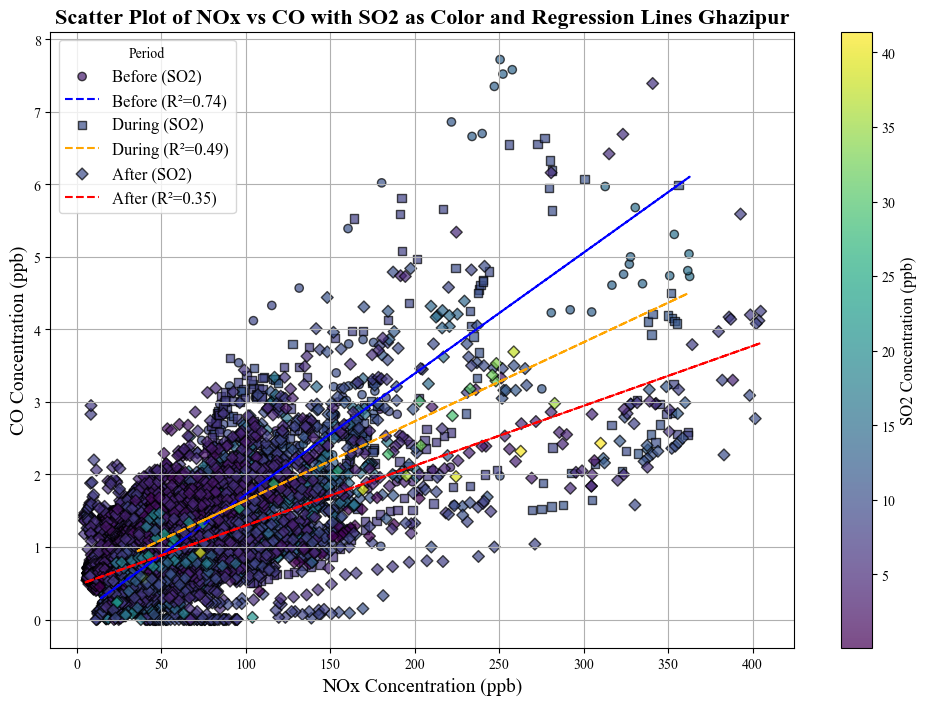

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib import rcParams
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Set font to Times New Roman
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'Times New Roman'
rcParams['text.usetex'] = False

# Define the file path
file_path = r'/Users/jayarajupakki/Documents/Phd/Project_Landfill_fires/Data/2024/Ghazipur/Patparganj_2024.xlsx'

# Load the Excel file
df = pd.read_excel(file_path, sheet_name=1)

# Convert 'From Date' to datetime and set as index
df['From Date'] = pd.to_datetime(df['From Date'], format='%d-%m-%Y %H:%M', errors='coerce')
df.set_index('From Date', inplace=True)

# Drop 'To Date' column if it's not needed
df.drop(columns='To Date', inplace=True, errors='ignore')

# Convert all columns to numeric, coerce errors to NaN
df = df.apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN in critical columns
df = df.dropna(subset=['NO', 'NO2', 'CO', 'SO2'])

# Add a period column based on the date (customize this based on your period definitions)
df['Period'] = np.where(df.index < '2024-01-15', 'Before',
                        np.where(df.index < '2024-02-01', 'During', 'After'))

# Calculate NOx from NO and NO2
df['NOx'] = df['NO'] + df['NO2']

# Plot setup
plt.figure(figsize=(12, 8))

# Define colors and markers for different periods
period_colors = {'Before': 'blue', 'During': 'orange', 'After': 'red'}
period_markers = {'Before': 'o', 'During': 's', 'After': 'D'}

# Create a scatter plot and store the handle for the color bar
scatter_handles = []

# Regression line plotting and R-squared calculation
for period, color in period_colors.items():
    period_data = df[df['Period'] == period]
    
    # Scatter plot
    scatter = plt.scatter(
        period_data['NOx'],
        period_data['CO'],
        c=period_data['SO2'],  # Use SO2 for the color dimension
        cmap='viridis',  # Color map for SO2
        norm=Normalize(vmin=df['SO2'].min(), vmax=df['SO2'].max()),
        label=f'{period} (SO2)',
        alpha=0.7,
        edgecolor='k',
        marker=period_markers[period]
    )
    
    scatter_handles.append(scatter)

    # Linear regression
    X = period_data[['NOx']].values
    y = period_data['CO'].values
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    
    # Plot regression line
    plt.plot(
        X, y_pred, 
        color=color, 
        linestyle='--',
        label=f'{period} (R²={r2:.2f})'
    )

# Add color bar using the last scatter plot's mappable
cbar = plt.colorbar(scatter_handles[-1])
cbar.set_label('SO2 Concentration (ppb)', fontsize=12)

# Plot details
plt.title('Scatter Plot of NOx vs CO with SO2 as Color and Regression Lines Ghazipur', fontsize=16, fontweight='bold')
plt.xlabel('NOx Concentration (ppb)', fontsize=14)
plt.ylabel('CO Concentration (ppb)', fontsize=14)
plt.legend(title='Period', fontsize=12)
plt.grid(True)

plt.show()
